<a href="https://colab.research.google.com/github/jelikaer/TallinnUrbanNoise/blob/main/Dataset_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tallinn Urban Noise dataset validation task using Simple audio recognition machine learning model.

The code source: https://www.tensorflow.org/tutorials/audio/simple_audio

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 44
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
!git clone https://github.com/jelikaer/TallinnUrbanNoise.git

fatal: destination path 'TallinnUrbanNoise' already exists and is not an empty directory.


In [ ]:
DATASET_PATH = '/content/TallinnUrbanNoise/data'

data_dir = pathlib.Path(DATASET_PATH)

tf.keras.utils.audio_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=32,
    sampling_rate=None,
    output_sequence_length=None,
    ragged=False,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False
)

Found 192019 files belonging to 9 classes.


<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'TallinnUrban.csv') & (commands != '.DS_Store') & (commands != 'new_csv_8kHZTallinnUrban.csv')]
print('Commands:', commands)

Commands: ['2' '6' '7' '3' '1' '4' '8' '9' '5']


In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=8000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 192019 files belonging to 9 classes.
Using 153616 files for training.
Using 38403 files for validation.

label names: ['1' '2' '3' '4' '5' '6' '7' '8' '9']


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)


(64, 8000)
(64,)


In [ ]:
label_names[[1,6,3,0]]

array(['2', '7', '4', '1'], dtype='<U1')

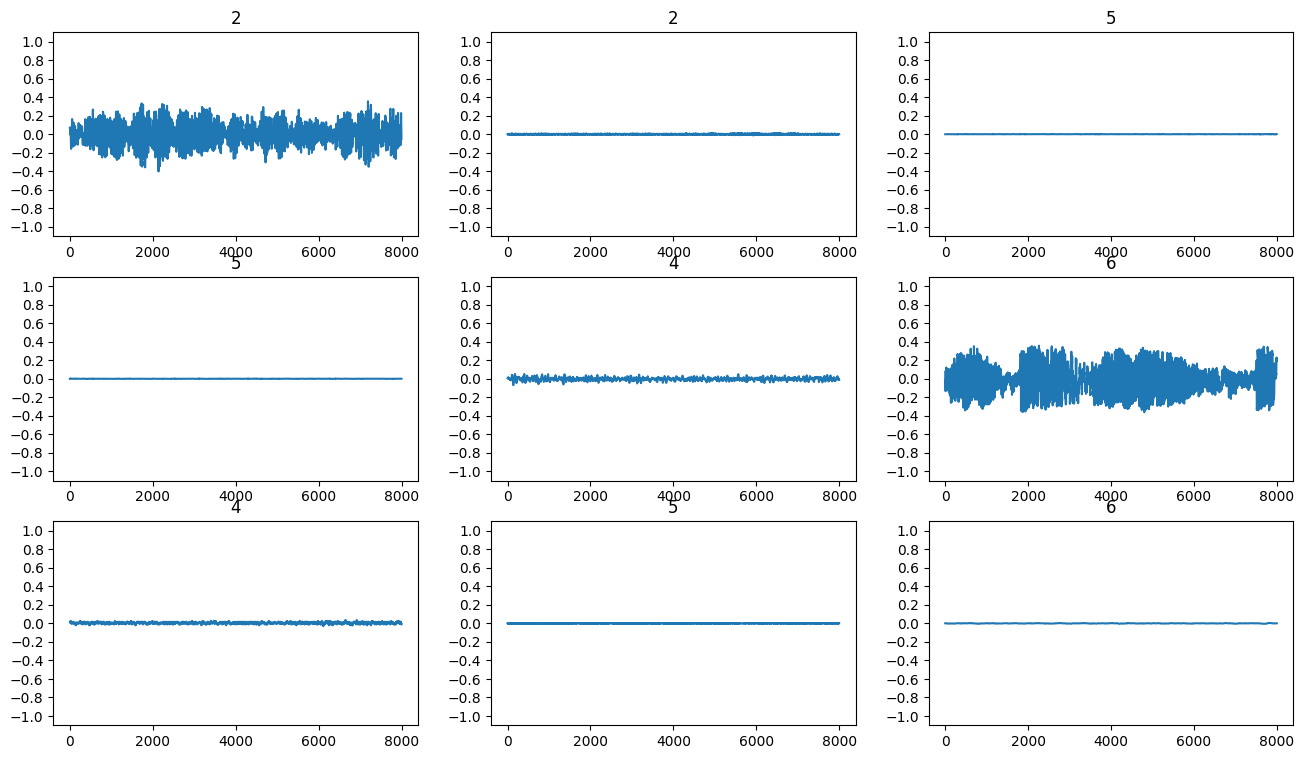

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
from IPython.display import Audio
from IPython.core.display import display
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display(Audio(waveform, rate=8000))

Label: 2
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 2
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 5
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

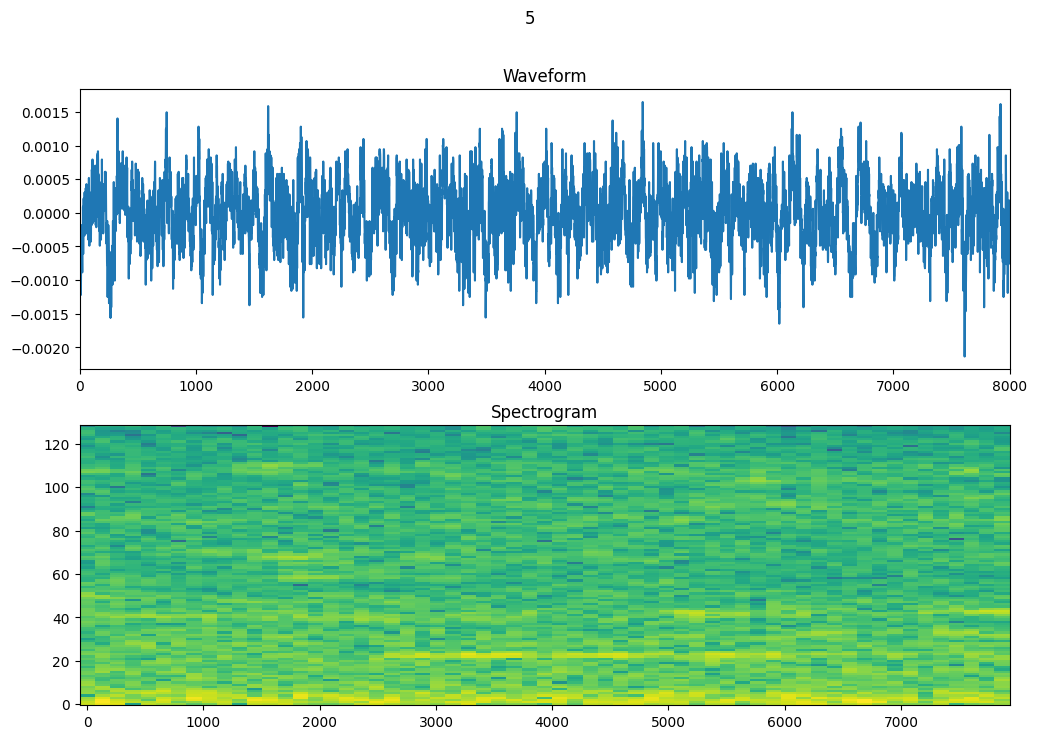

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

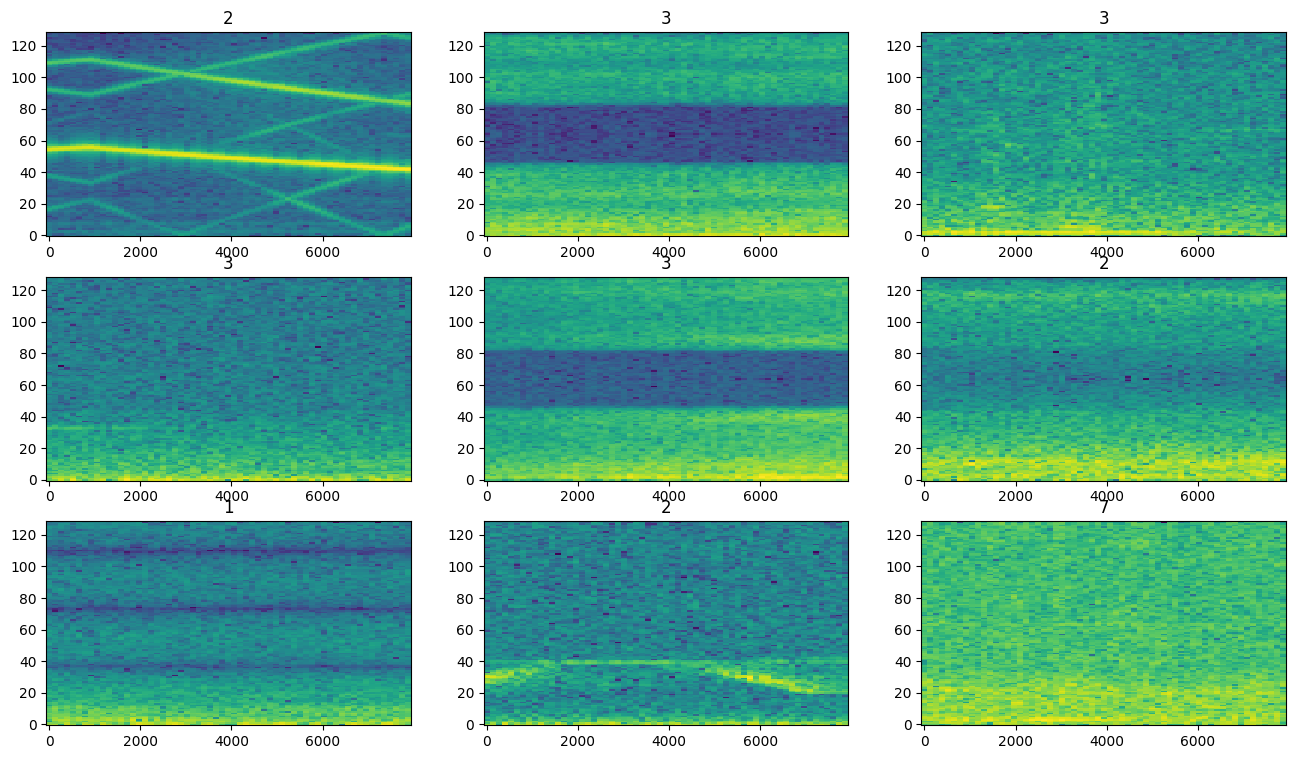

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow import keras
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
layers = keras.layers
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = keras.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (61, 129, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)        

In [ ]:
# Define the model
def create_convolutional_model(input_shape=(61, 129, 1), output_shape=(None, 9)):
    model = models.Sequential()

    # Convolutional layer
    model.add(layers.DepthwiseConv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output of the convolutional layer
    model.add(layers.Flatten())

    # Fully connected (dense) layer
    model.add(layers.Dense(9, activation='softmax'))

    return model

# Create the model
model = create_convolutional_model()

# Print model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d_15 (Depth  (None, 10, 33, 1)         1025      
 wiseConv2D)                                                     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 16, 1)          0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 80)                0         
                                                                 
 dense_27 (Dense)            (None, 9)                 729       
                                                                 
Total params: 1754 (6.85 KB)
Trainable params: 1754 (6.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

inputs = keras.Input(shape=input_shape)
x = keras.layers.DepthwiseConv2D(kernel_size=5)(inputs)
fullConnection = keras.layers.Dense(3, activation='softmax')(x)
output = keras.layers.Dense(2)(fullConnection)
fullConnection3 = keras.layers.Flatten()(output)
output2 = keras.layers.Dense(9, activation='softmax') (fullConnection3)

model = keras.Model(inputs=inputs, outputs=output2)


# layers = keras.layers
# # Instantiate the `tf.keras.layers.Normalization` layer.
# norm_layer = layers.Normalization()
# # Fit the state of the layer to the spectrograms
# # with `Normalization.adapt`.
# norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

# model = keras.Sequential([
#     layers.Input(shape=input_shape),
#     # Downsample the input.
#     layers.Resizing(32, 32),
#     # Normalize.
#    norm_layer,
#     layers.Conv2D(32, 3, activation='relu'),
# #     layers.Conv2D(64, 3, activation='relu'),
# #     layers.
# #     layers.MaxPooling2D(),
# #     layers.Dropout(0.25),
# #     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_labels, activation='softmax'),
# ])

model.summary()

Input shape: (61, 129, 1)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 61, 129, 1)]      0         
                                                                 
 depthwise_conv2d_17 (Depth  (None, 57, 125, 1)        26        
 wiseConv2D)                                                     
                                                                 
 dense_31 (Dense)            (None, 57, 125, 3)        6         
                                                                 
 dense_32 (Dense)            (None, 57, 125, 2)        8         
                                                                 
 flatten_12 (Flatten)        (None, 14250)             0         
                                                                 
 dense_33 (Dense)            (None, 9)                 128259    
                                 

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
print('ready')

ready


In [ ]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
2401/2401 [==============================] - 10s 4ms/step - loss: 1.3017 - accuracy: 0.5434 - val_loss: 1.0854 - val_accuracy: 0.6160
Epoch 2/50
2401/2401 [==============================] - 9s 4ms/step - loss: 1.1146 - accuracy: 0.6077 - val_loss: 0.9965 - val_accuracy: 0.6445
Epoch 3/50
2401/2401 [==============================] - 9s 4ms/step - loss: 1.0295 - accuracy: 0.6342 - val_loss: 0.9236 - val_accuracy: 0.6701
Epoch 4/50
2401/2401 [==============================] - 9s 4ms/step - loss: 0.9681 - accuracy: 0.6520 - val_loss: 0.8905 - val_accuracy: 0.6771
Epoch 5/50
2401/2401 [==============================] - 9s 4ms/step - loss: 0.9250 - accuracy: 0.6690 - val_loss: 0.8329 - val_accuracy: 0.7007
Epoch 6/50
2401/2401 [==============================] - 9s 4ms/step - loss: 0.8881 - accuracy: 0.6810 - val_loss: 0.8283 - val_accuracy: 0.7037
Epoch 7/50
2401/2401 [==============================] - 9s 4ms/step - loss: 0.8541 - accuracy: 0.6944 - val_loss: 0.7903 - val_accuracy

Text(0, 0.5, 'Accuracy [%]')

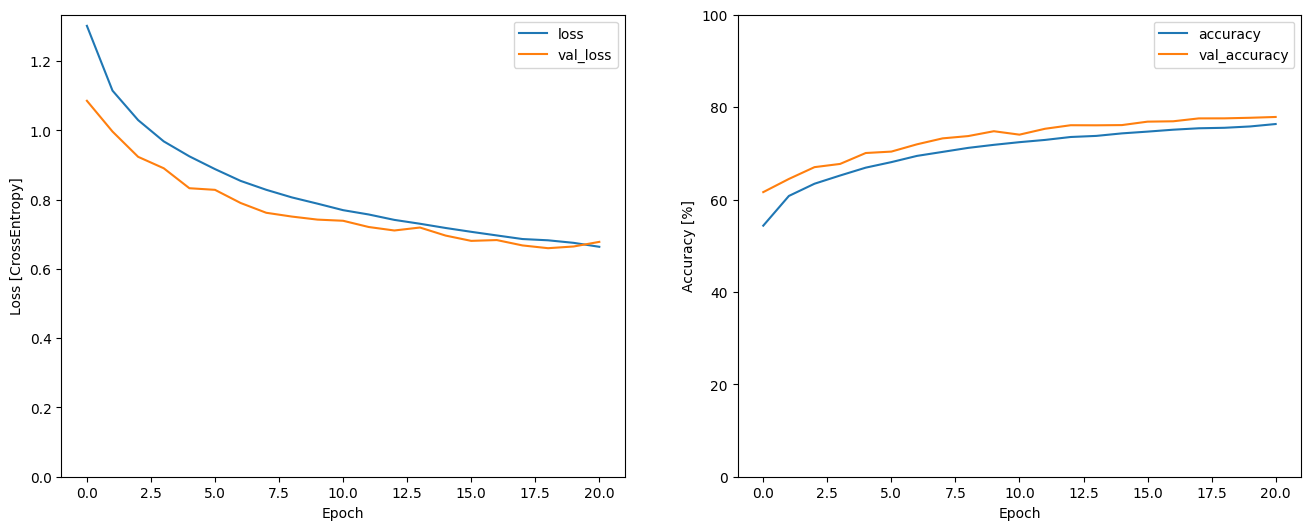

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

301/301 [==============================] - 1s 3ms/step - loss: 0.6726 - accuracy: 0.7814


{'loss': 0.6725620031356812, 'accuracy': 0.7813883423805237}

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

301/301 [==============================] - 1s 2ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

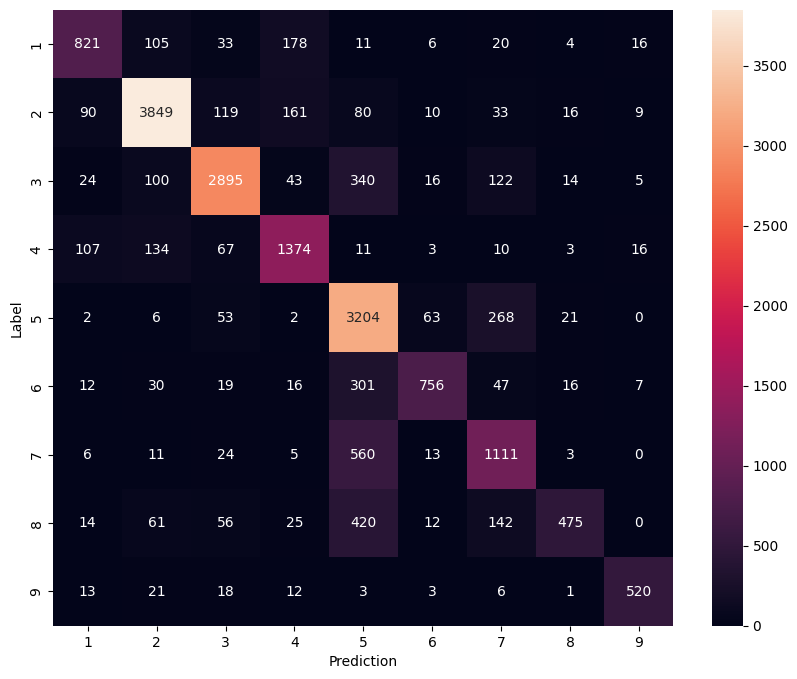

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

tf.Tensor(
[[-1.4393005   0.99738806 -1.4749448  -3.1431053  -0.8389226  -2.659071
  -0.67619276 -0.9307922  -4.1673126 ]], shape=(1, 9), dtype=float32)


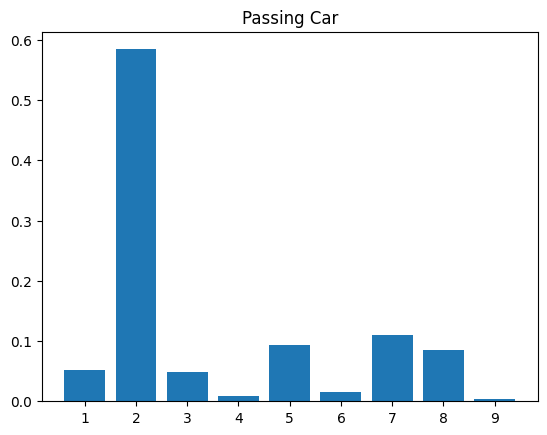

In [ ]:
x = '/content/car.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
print(prediction)
x_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Passing Car')
plt.show()

display(Audio(waveform, rate=8000))